# Test `tracer_thalweg_and_surface_hourly` Module

Render figure object produced by the `nowcast.figures.research.tracer_thalweg_and_surface_hourly` module.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker
to help ensure that the module will work in the nowcast production context.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

In [1]:
# reload lets us pull in changes from modules that we edit
from importlib import reload

In [2]:
# imports from the top of the make_plots worker that we need for the test
from pathlib import Path

import arrow
import netCDF4 as nc

from nowcast.figures.research import tracer_thalweg_and_surface_hourly

In [3]:
# some extra imports that we need to simulate how the nowcast system works
import io

import yaml

Python and library versions:

In [4]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import numpy
import sys
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.13.1 | packaged by conda-forge | (main, Jan 13 2025, 09:53:10) [GCC 13.3.0]'
numpy.__version__='2.2.1'
xarray.__version__='2025.1.1'
bottleneck.__version__='1.4.2'
h5netcdf.__version__='1.4.1'
h5py.__version__='3.12.1'
matplotlib.__version__='3.10.0'
cmocean.__version__='v3.0.3'


## Simulate Nowcast System Config

The `config` multiline string contains the pieces of `nowcast/config/nowcast.yaml`
that are needed to set up the conditions as `nowcast.workers.make_plots` does
before calling the figure module `make_figure()` function.

The `yaml.load()` call at the bottom of the cell converts the string into a `config` dict.

In [15]:
config = '''
    run_types:
        nowcast-green:
            bathymetry: /SalishSeaCast/grid/bathymetry_201702.nc
            mesh_mask: /SalishSeaCast/grid/mesh_mask201702.nc

    run:
        results_archive:
            nowcast-green: /results2/SalishSea/nowcast-green.202111/
'''

config = yaml.safe_load(io.StringIO(config))

## Simulate the `make_plots` Command-line Interface

`make_plots` gets `run_type`, `plot_type`, and `run_date` from the command-line.

In [16]:
run_type = 'nowcast-green'
plot_type = 'research'
run_date = arrow.get('2025-01-25')

## Simulate the Set-up of Variables and Paths in the `make_plots.make_plots()` Function

The `make_plots()` function uses paths defined in the nowcast system configuration file
to set up a collection of commonly used variables, paths, and datasets.
These are just the ones that we need for our test.

In [17]:
dmy = run_date.format('DDMMMYY').lower()
results_dir = Path(config['run']['results_archive'][run_type], dmy)
bathy = nc.Dataset(config['run_types'][run_type]['bathymetry'])
mesh_mask = nc.Dataset(config['run_types']['nowcast-green']['mesh_mask'])

## Simulate Dataset Loading in `_prep_nowcast_green_research_fig_functions()`

This has the same effect as:
```python
    biol_T_hr = _results_dataset("1h", "biol_T", results_dir)
```

In [19]:
yyyymmdd = run_date.format('YYYYMMDD')
biol_T_hr = nc.Dataset(results_dir/f'SalishSea_1h_{yyyymmdd}_{yyyymmdd}_biol_T.nc')

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

The `reload()` calls reload imported modules so that any edits you have made will take effect here.

The `make_figure()` call should be the same as goes in the `make_plots` worker module.

2.82 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


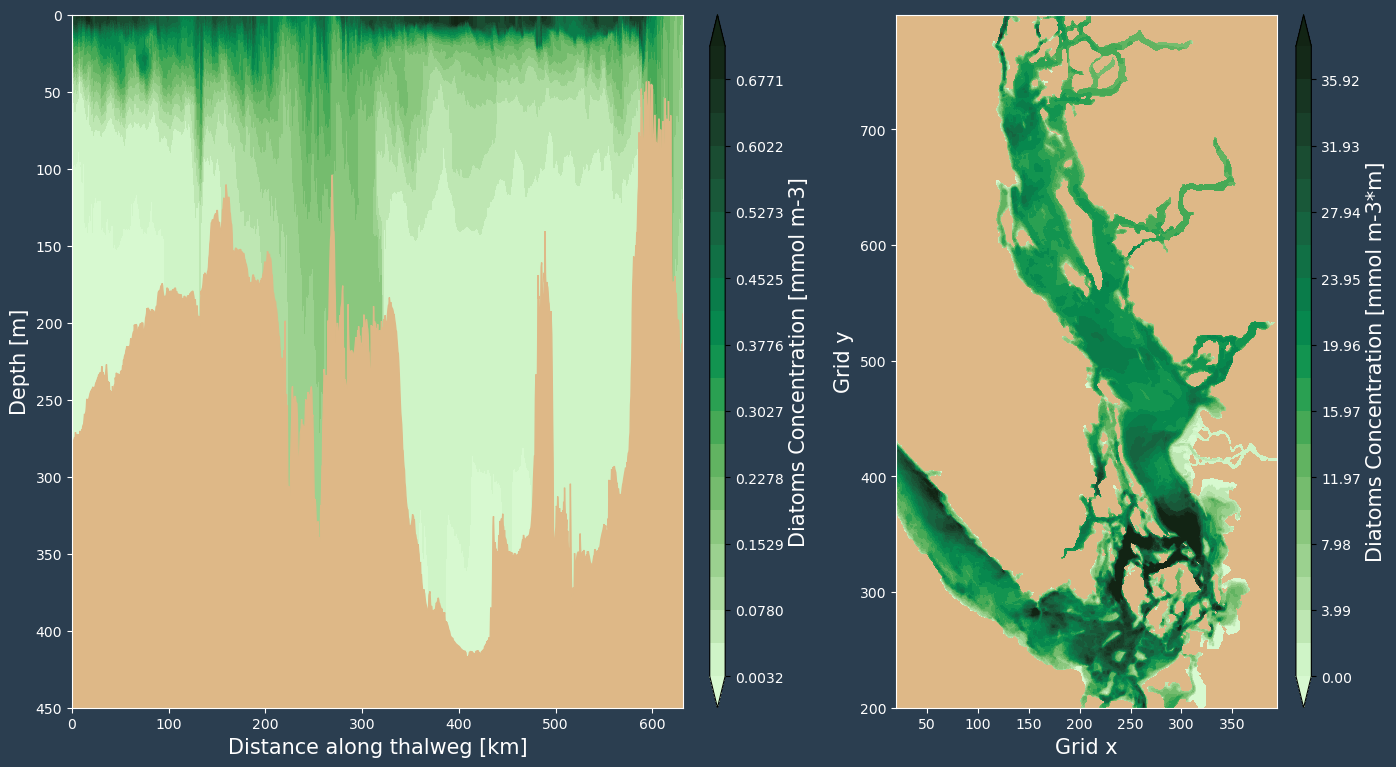

In [20]:
%%timeit -n1 -r1

reload(tracer_thalweg_and_surface_hourly)

var = 'diatoms'
clevels_thalweg, clevels_surface = tracer_thalweg_and_surface_hourly.clevels(
    biol_T_hr.variables[var], mesh_mask, depth_integrated=True)
hr = 0
fig = tracer_thalweg_and_surface_hourly.make_figure(
    hr, biol_T_hr.variables[var], bathy, mesh_mask,
    clevels_thalweg, clevels_surface, cmap=cmocean.cm.algae, depth_integrated=True
)